In [2]:
# imports
import os
import gc
import sys
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from random import shuffle
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc, roc_curve, log_loss

import warnings; warnings.simplefilter('ignore')

In [7]:
# cnn imports
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout

In [8]:
from sklearn.model_selection import train_test_split

gtFr = pd.read_csv('data/gt.csv')

trainIdx, testIdx = train_test_split(gtFr, test_size=0.2)

# Plot some images

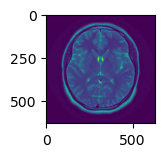

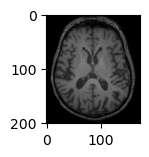

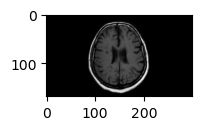

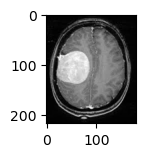

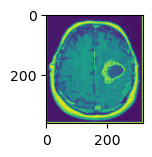

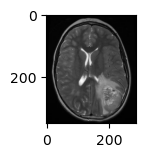

In [9]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder_no = 'images/archive/brain_tumor_dataset/no'
folder_yes = 'images/archive/brain_tumor_dataset/yes'

i = 0

for filepath, gt in zip([folder_no,folder_yes],[0,1]):

    # plot first few images
    for f in os.listdir(filepath)[0:3]:
        
        i = i+1

        # define subplot
        pyplot.subplot(330 + 1 + i)

        # define filename
        filename = filepath + '/' + f

        # load image pixels
        image = imread(filename)

        # plot raw pixel data
        pyplot.imshow(image)

        # show the figure
        pyplot.show()

# Read images into array

In [111]:
filepath = 'images/archive/brain_tumor_dataset/'

images, labels, filenames = [], [], []

for gt in ['yes','no']:
    
    filepath_gt = filepath + gt
    
    for f in os.listdir(filepath_gt):

        filename = filepath_gt + '/' + f
        #print(filename)

        # load image
        photo = load_img(filename, target_size=(200, 200))

        # load image pixels
        image = imread(filename)

        # plot raw pixel data
        #pyplot.imshow(image)

        # plot image
        #pyplot.show()

        # store to array
        images.append(image)
        filenames.append(filename)
        
        if gt=='yes':
            label = 1
            labels.append(label)
        elif gt=='no':
            label = 0
            labels.append(label)            

In [120]:
from sklearn.model_selection import train_test_split

gtFr = pd.DataFrame(labels).rename(columns={0:'gt'}).reset_index(drop=False).rename(columns={'index':'pID'})
gtFr['filename'] = filenames

# split into training and testing sets, stratifying by gt for equal representation
trainFr, testFr = train_test_split(gtFr, test_size=0.2, stratify=gtFr['gt'])

# store training/testing indices
trainFr['set'] = 'train'
testFr['set'] = 'test'

gtFr2 = pd.concat([trainFr,testFr],axis=0)
gtFr2.set_index(['filename']).to_csv('gtFr.csv')

In [ ]:
# Set data and label
X = np.array([np.array(i[0]) for i in training_data]).reshape(-1, len(variable_orders), 25+1, 1) # features

y = np.array([i[1] for i in training_data]) # ground truth

pID_arr = np.array([i[2] for i in training_data]) # pID array

In [ ]:
yfull_train = dict()
yfull_test = []

# 6-fold cross-validation
cv = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=random_state)

# Build series of models
num_fold = 0
sum_score = 0
models = []

# Train models
results_full = pd.DataFrame()

for train_index, test_index in cv.split(X, y):
    print "Running Fold", num_fold+1, "/", n_folds

    # Create model
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape=(np.shape(X)[1],np.shape(X)[2],1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="th",padding='same'))

    model.add(Conv2D(64,(2,2),padding="same")) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="th",padding='same'))

    model.add(Conv2D(128,(2,2),padding="same")) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="th",padding='same'))

    model.add(Conv2D(128,(2,2),padding="same")) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="th",padding='same'))

    model.add(Conv2D(128,(3,3),padding="same")) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="th",padding='same'))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Dropout(0.5))
    model.add(Activation('sigmoid'))

    optimizer = keras.optimizers.rmsprop(lr=LR, decay=1e-6)
    model.compile(optimizer = optimizer,
                   loss ='binary_crossentropy',
                   metrics =['accuracy'])

    num_fold += 1

    # Separate data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pID_train, pID_test = pID_arr[train_index], pID_arr[test_index]

    # Fit model
    model.fit(X_train, y_train, epochs=nb_epoch, verbose=0, validation_data=(X_test, y_test), shuffle=True)

    #print model.summary()

    models.append(model)

    #Save history
    with open('results'+'.txt', 'wb') as file_pi:  
        pickle.dump(model.history, file_pi)

    # Make predictions
    result = model.predict(X_test, verbose=2)

    yfull_test.append(result)

    # Store predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = result[i]

    resultsFr = pd.DataFrame()
    resultsFr['pID'] = pID_test
    resultsFr['gt'] = y_test
    resultsFr['nqloc'] = result
    resultsFr['task'] = 1

    results_full = results_full.append(resultsFr)